# Classifying digits using a fully connected neural network
# Student: César Almecija

In this practical exercice a fully connected neural network (also called multi-layer perceptron) is built using keras. It is then trained to classify image digits from the MNIST database.

Some baseline results:

| Method                                                                      | Test error (%) |
|-----------------------------------------------------------------------------|---------------:|
| Linear classifier (LeCun et al. 1998)                                       |           12.0 |
| K-nearest-neighbors, Euclidean (L2) (LeCun et al. 1998)                     |            5.0 |
| 3-layer NN, 500-300, softmax, cross entropy, weight decay (Hinton, 2005)    |            1.5 |
| Convolutional net LeNet-4 (LeCun et al. 1998)                               |            1.1 |
| Virtual SVM deg-9 poly [data augmentation] (LeCun et al. 1998)              |            0.8 |
| 6-layer NN with [data augmentation] (Ciresan et al. 2010)                   |           0.35 |
| Deep conv. net, 7 layers [data augmentation] (Ciresan et al. IJCAI 2011)    |           0.35 |

More results are available from: http://yann.lecun.com/exdb/mnist/

Try to improve on some of these results, at least on those that do not use data augmentation or convolutional neural networks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist as db
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2


11501568/11490434 [==============================] - 0s 0us/step


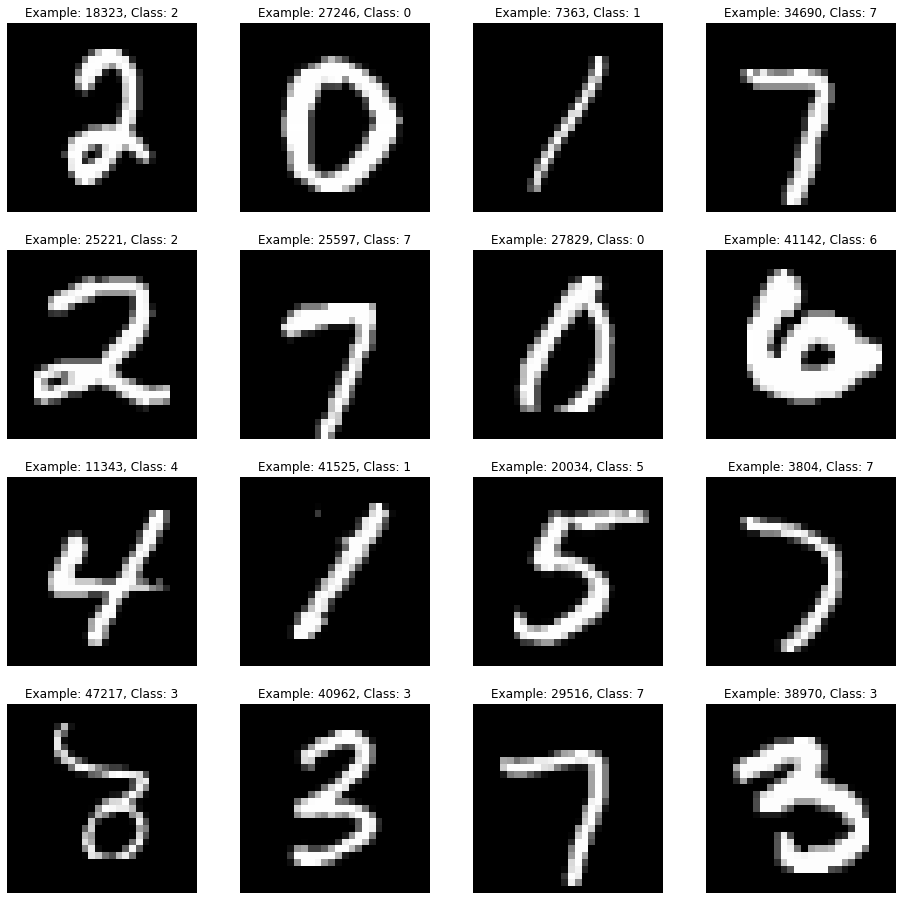

In [3]:
# Load and have a look at the data
(x, y), (x_test_ori, y_test_ori) = db.load_data()

# Visualize a single digit, with its class
plt_r,plt_c = 4,4
f, ax = plt.subplots(plt_r, plt_c, figsize=(16,16))
for i in range(plt_r):
    for j in range(plt_c):
        index = np.random.randint(x.shape[0])
        ax[i][j].imshow(x[index])
        ax[i][j].axis('off')
        ax[i][j].set_title("Example: {}, Class: {}".format(index, y[index]))
plt.show()

# Data preparation

The training subset of the MNIST database contains 60000 images. A fraction of them (6000 by default) will be used for validation; the rest for training.

Note that pixel values are normalized by simply dividing by 255.

In [4]:
# Data management
val_nb = 6000  # number of validation samples
nb_samples = x.shape[0]

if val_nb > nb_samples:
    raise ValueError("You need some samples to train your network!")

img_width, img_height = x.shape[1], x.shape[2]

num_of_pixels = img_width * img_height

# Normalization
x = x.astype('float32')
x_test = x_test_ori.astype('float32')
x /= 255
x_test /= 255

# Dividing between training and validation
x_val_ori = x[:val_nb, ]
x_train = x[val_nb:, ]
y_val_ori = y[:val_nb]
y_train = y[val_nb:]

# As we are using only fully connected layers, we need a vector as input
# Thus, an image becomes a vector of size num_of_pixels
# (whereas, before, it was a matrix of size (img_width, img_height))
x_train = x_train.reshape(nb_samples - val_nb, num_of_pixels)
x_val = x_val_ori.reshape(val_nb , num_of_pixels)
x_test = x_test_ori.reshape(x_test_ori.shape[0], num_of_pixels)

# one-hot encoding of classes
num_classes = max(y) + 1 # starts at 0
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val_ori, num_classes)
y_test = to_categorical(y_test_ori, num_classes)


print(x_train.shape, 'x train samples')
print(x_val.shape, 'x val samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_val.shape, 'y val samples')
print(y_test_ori.shape, 'y test samples')

(54000, 784) x train samples
(6000, 784) x val samples
(10000, 784) x test samples
(54000, 10) y train samples
(6000, 10) y val samples
(10000,) y test samples


# First model

We will begin with a network containing a single layer.


In [5]:
# let define a first simple model without any hidden layers
model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=(x_train.shape[1],)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


# Model training

The following section takes care of training.

Firstly, the model has to be 'compiled'. This operations lets the user to choose the loss, the optimizer and the metrics, then configures the model for training.

Secondly, the 'fit' method runs the optimization. Training and validation data are specified here, as well as batch size and the number of epochs.


In [6]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy']) # how to measure how good is the model.

# For the loss, we use the classical crossentropy: it takes only into account the output concerning the actual class of the image.
# For the optimizer, we use a simple gradient descent
# To measure how good the model is, we use the "accuracy" metrics. It simply divides the number of correct predictions () by the total number of predictions made.
# (a correct prediction: when the actual class matches the output with highest probability)

Note that you can run the cell below several times. Training will restart from the point it stopped in the previous run. However variable *output* will only contain the history of the last run.

In [7]:
batch_size = 128
epochs = 20
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val))

# We train our model.
# batch_size is the number of samples (training images) used at each iteration of the gradient descent.
# => they are randomly chosen in the training set and are used to calculate the loss (loss = sum of cross-entropy on each prediction)

Epoch 1/20
422/422 [==============================] - 4s 4ms/step - loss: 1.3207 - accuracy: 0.6878 - val_loss: 0.8531 - val_accuracy: 0.8202
Epoch 2/20
422/422 [==============================] - 1s 3ms/step - loss: 0.7483 - accuracy: 0.8355 - val_loss: 0.6370 - val_accuracy: 0.8570
Epoch 3/20
422/422 [==============================] - 1s 4ms/step - loss: 0.6114 - accuracy: 0.8551 - val_loss: 0.5488 - val_accuracy: 0.8712
Epoch 4/20
422/422 [==============================] - 1s 3ms/step - loss: 0.5454 - accuracy: 0.8652 - val_loss: 0.4991 - val_accuracy: 0.8777
Epoch 5/20
422/422 [==============================] - 1s 4ms/step - loss: 0.5050 - accuracy: 0.8721 - val_loss: 0.4663 - val_accuracy: 0.8833
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 0.4773 - accuracy: 0.8775 - val_loss: 0.4429 - val_accuracy: 0.8872
Epoch 7/20
422/422 [==============================] - 1s 3ms/step - loss: 0.4568 - accuracy: 0.8810 - val_loss: 0.4251 - val_accuracy: 0.8918
Epoch 

# Is training satisfactory?

Looking at the evolution of training and validation accuracies, one can evaluate the quality of training.

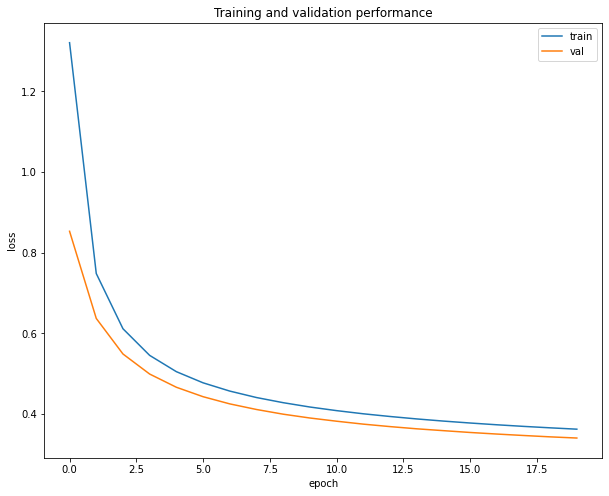

In [8]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


# Questions



*   Do you think learning could be improved? Why?

**Answer**: yes, I think it could be improved. We have only used a single layer, we can now try to add more of them.

*   Is there overfitting? Why?

**Answer**: when I ran the model, I did not notice any clear overfitting. The training loss and the validation loss have always been very close (we would have had overfitting if the validation loss had risen and the training loss lowered).



# Analysis of the weights

With this simple model it is possible to have an intuition of what the neural network has learned looking at
the matrix of the weights $W$. 
In fact $W\in\mathbb{R}^{784\times 10}$, so for each class $i$ we can plot the weights corresponding to this class.

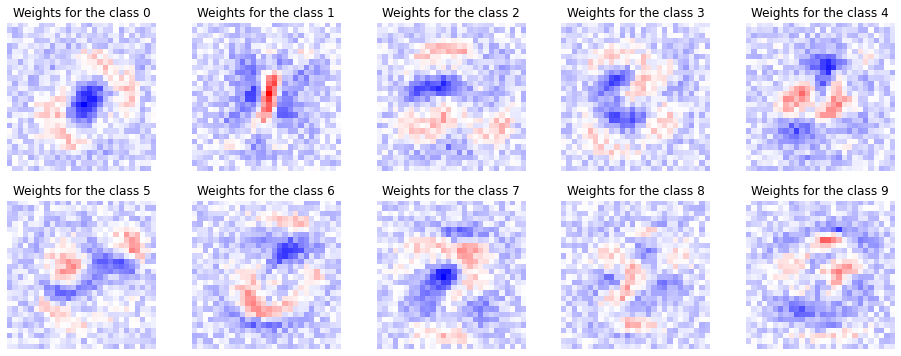

In [9]:
# plotting the weights 
W, b = model.layers[0].get_weights()
vmin = W.min()
vmax = W.max()
f, ax = plt.subplots(2, 5, figsize=(16,6))
for plt_row in range(2):
    for plt_col in range(5):
        ax[plt_row][plt_col].imshow(W[:,plt_row*5 + plt_col].reshape(img_width,img_height), vmin=vmin, vmax=vmax, cmap=plt.cm.bwr)
        ax[plt_row][plt_col].axis('off')
        ax[plt_row][plt_col].set_title("Weights for the class {}".format(plt_row*5 + plt_col))
plt.show()

# Improving performance by adding extra layers

In order to improve the performances of our prediction it is possible to add hidden layers between the input layer and the output layer.

Note that here we are restricted to dense layers. Do not use (yet) other types of layers.

In [31]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax', name="last"))

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
last (Dense)                 (None, 10)                1290      
Total params: 151,306
Trainable params: 151,306
Non-trainable params: 0
_________________________________________________________________


In [32]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [33]:
batch_size = 64
epochs = 20
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Epoch 1/20
844/844 [==============================] - 4s 4ms/step - loss: 1.1397 - accuracy: 0.6955 - val_loss: 0.4136 - val_accuracy: 0.8842
Epoch 2/20
844/844 [==============================] - 3s 4ms/step - loss: 0.3590 - accuracy: 0.8951 - val_loss: 0.2932 - val_accuracy: 0.9160
Epoch 3/20
844/844 [==============================] - 3s 4ms/step - loss: 0.2827 - accuracy: 0.9173 - val_loss: 0.2402 - val_accuracy: 0.9337
Epoch 4/20
844/844 [==============================] - 3s 4ms/step - loss: 0.2393 - accuracy: 0.9295 - val_loss: 0.2088 - val_accuracy: 0.9388
Epoch 5/20
844/844 [==============================] - 3s 4ms/step - loss: 0.2088 - accuracy: 0.9384 - val_loss: 0.1876 - val_accuracy: 0.9443
Epoch 6/20
844/844 [==============================] - 3s 4ms/step - loss: 0.1861 - accuracy: 0.9449 - val_loss: 0.1683 - val_accuracy: 0.9500
Epoch 7/20
844/844 [==============================] - 3s 4ms/step - loss: 0.1682 - accuracy: 0.9512 - val_loss: 0.1656 - val_accuracy: 0.9508
Epoch 

# Analysis of the results




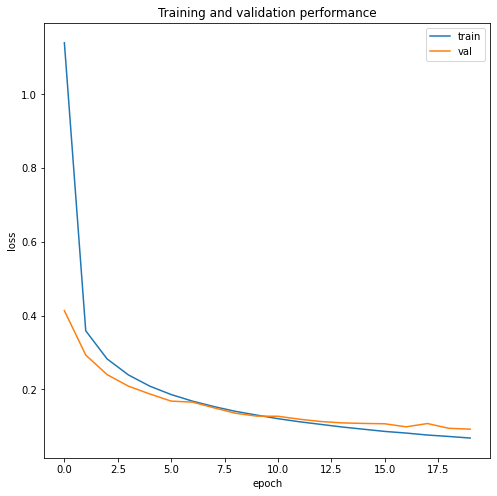

In [34]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
# plt.ylim(0.2, 0.8)

Is there overfitting? How can it be reduced?

**Answer**: we notice a slight overfitting towards the end of the iterations. We could solve this by reducing the number of epochs (the model would not have the "time" to begin to overfit). We could also add a regularization term in the loss function, but it would certainly slow the training down (we have 150,000+ params).

# Qualitative error analysis

Let us have a look at some images that have been incorrectly classified.

By changing the *index* variable below you can inspect different errors.

Correct label is:  8
Predicted label is:  5
Probabilities:  [0.00484172 0.05239818 0.00704357 0.03609167 0.22418064 0.50816464
 0.05954779 0.00874447 0.04893114 0.05005622]


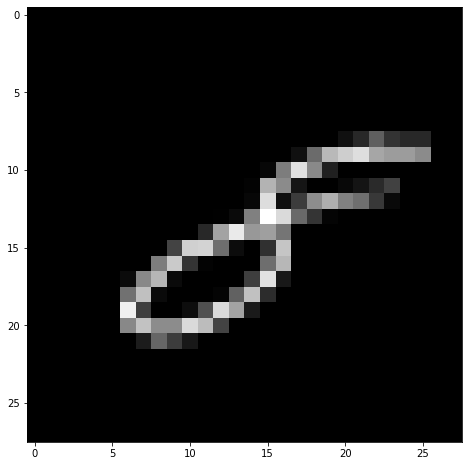

In [14]:
y_predict_proba = model.predict(x_val)
y_predict = np.argmax(y_predict_proba, 1)

err_mask = y_val_ori != y_predict
ok_mask = y_val_ori == y_predict

x_val_errors = x_val_ori[err_mask]
y_val_errors = y_val_ori[err_mask]
y_predict_errors = y_predict[err_mask]
y_predict_proba_errors = y_predict_proba[err_mask]
y_predict_proba_ok = y_predict_proba[ok_mask]

index = 10
print("Correct label is: ", y_val_errors[index])
print("Predicted label is: ", y_predict_errors[index])
print("Probabilities: ", y_predict_proba_errors[index])
plt.imshow(x_val_errors[index], cmap="gray")
plt.show()

In [15]:
# p.max() keeps the highest probability among the 10 outputs.

y_predict_proba_errors = np.max(y_predict_proba_errors, 1)
y_predict_proba_ok = np.max(y_predict_proba_ok, 1)


In [16]:
# np.random.shuffle shuffles the values of the array
np.random.shuffle(y_predict_proba)
np.random.shuffle(y_predict_proba_ok)

In [17]:
y_predict_proba_errors.shape

(172,)

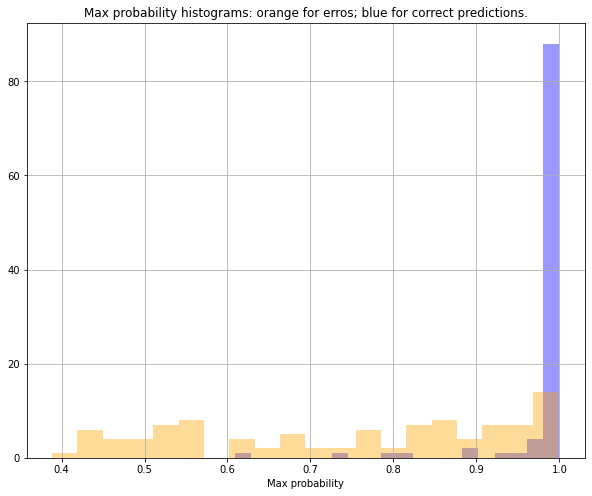

In [18]:
histo_bins = 20
plt.hist(y_predict_proba_ok[0:100], density=False, bins=histo_bins,color="blue", alpha=0.4)
plt.hist(y_predict_proba_errors[0:100],density=False, bins=histo_bins,color="orange", alpha=0.4)
plt.title('Max probability histograms: orange for erros; blue for correct predictions.')
plt.xlabel("Max probability")
plt.grid()

Is the network 'confident' when making errors?

**Answer**: when making errors, the network is not confident, because we notice that approximately 90% of the wrongly predicted images had a maximum probability lower than 0.9. More generally, the maximum probabilities of wrongly predicted images are more or less uniformly distributed over $[0,1]$. Furthermore, when we compare it with the correctly predicted images, those have a maximum probability *a.e.* > 0.99.

What do you think about these errors?

**Answer**: I do not think these errors are a problem. I took a look at the wrongly predicted images, and could almost never tell the correct class without looking at the image caption.

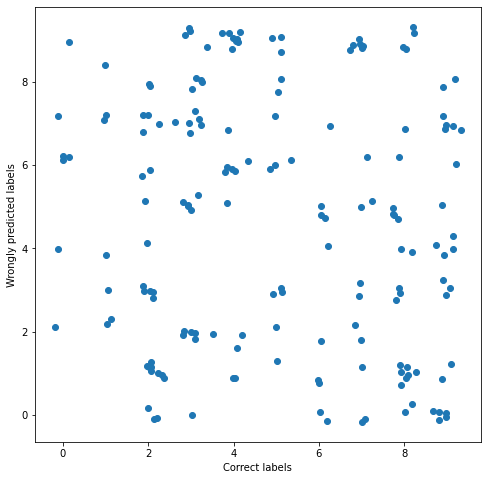

In [19]:
# Error visualization

plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(8,8))

# Some noise is added to the ground-truth and predictions so
# that they do not overlap on the figure. 
y_val_errors_2 = y_val_errors + np.random.randn(len(y_val_errors))*0.15
y_predict_errors_2 = y_predict_errors + np.random.randn(len(y_predict_errors))*0.15
plt.scatter(y_val_errors_2, y_predict_errors_2)
plt.xlabel('Correct labels')
plt.ylabel('Wrongly predicted labels')
plt.show()

# Analysing the last layer

Each neuron $i$ in the last layer of the network corresponds to one class. Its weights $W_i$ can be interpreted as the parameters of a hyperplane $H_i$ of $R^d$, where $d$ is the number of neurons of the previous layer.

If two classes are correctly separated by the network, one can expect that the two corresponding hyperplanes are orthogonal. This can be evaluated by calculating the cosine between their normal vectors. This measure is called.... cosine similarity.

Note that as $d$ increases, the expected value of the cosine of two random normal vectors of $R^d$ converges towards zero. Put otherwise: in high dimension, two random vectors tend to be orthogonal.

Shape of the weights array: (128, 10)


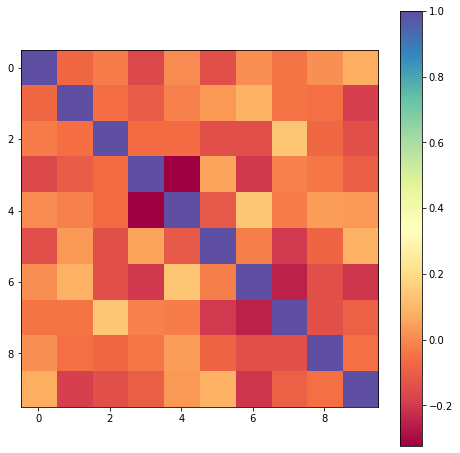

In [20]:
weights, bias = model.get_layer("last").get_weights()
print("Shape of the weights array:", weights.shape)
norms = []
for neuron in range(weights.shape[1]):
    norms += [np.linalg.norm(weights[:,neuron])]
weights /= norms

cos = np.matmul(weights.transpose(), weights)

plt.imshow(cos[0:400, 0:400])
plt.set_cmap('Spectral')
plt.colorbar()
plt.show()

Which classes seem to be the most correlated? Would you have expected this?

**Answer**: "two classes being correlated" can be translated as : "two hyperplanes being not orthogonal". Thus, we are looking for the classes that have a cosine close to $1$ (meaning their normal vector are colinear).

Obviously, each class is highly correlated with itself (cosine equals 1). However, if we exclude this situation, the ones that seem to be most correlated are the class 2 with the class 7 and the class 4 with the class 6. I would perhaps have expected it with 2 and 7 (when drawn quickly, they may look alike), but not with 4 and 6.

# Improving your network

Try to improve the performance of your network: try different numbers of layers, as well as the number of neurons per layer.

What is your best validation accuracy?

**Answer**: I got 0.979 (which is almost 1% better than the result I got with the previous NN). I added two layers and multiplied by 2 the number of neurons per layer (except for the last layer). Here is the code I used.

In [25]:
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(num_classes, activation='softmax', name="last"))

model2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
last (Dense)                 (None, 10)               

In [26]:
learning_rate = 0.01
model2.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [27]:
batch_size = 64
epochs = 20
output = model2.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Epoch 1/20
844/844 [==============================] - 5s 5ms/step - loss: 1.1957 - accuracy: 0.6796 - val_loss: 0.3684 - val_accuracy: 0.8932
Epoch 2/20
844/844 [==============================] - 4s 4ms/step - loss: 0.3241 - accuracy: 0.9029 - val_loss: 0.2593 - val_accuracy: 0.9227
Epoch 3/20
844/844 [==============================] - 4s 4ms/step - loss: 0.2424 - accuracy: 0.9285 - val_loss: 0.2048 - val_accuracy: 0.9420
Epoch 4/20
844/844 [==============================] - 4s 5ms/step - loss: 0.1943 - accuracy: 0.9427 - val_loss: 0.1926 - val_accuracy: 0.9440
Epoch 5/20
844/844 [==============================] - 4s 5ms/step - loss: 0.1636 - accuracy: 0.9516 - val_loss: 0.1494 - val_accuracy: 0.9570
Epoch 6/20
844/844 [==============================] - 4s 5ms/step - loss: 0.1404 - accuracy: 0.9586 - val_loss: 0.1339 - val_accuracy: 0.9625
Epoch 7/20
844/844 [==============================] - 4s 5ms/step - loss: 0.1239 - accuracy: 0.9629 - val_loss: 0.1311 - val_accuracy: 0.9613
Epoch 

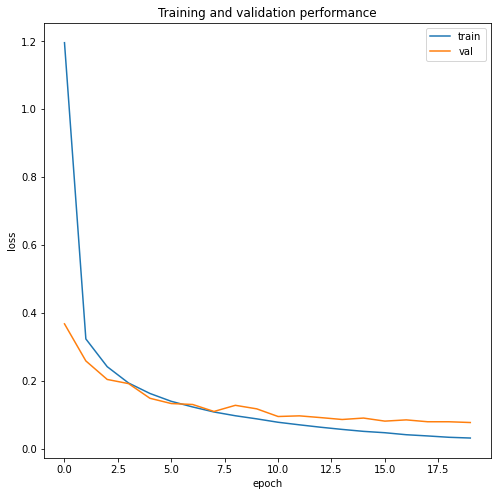

In [28]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
# plt.ylim(0.2, 0.8)

# Testing

Testing is the last stage of the learning process. Good practice recommends to do it only once, when you have completely finished with the optimization of the network parameters and hyperparameters.

In [35]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Test loss: 16.608
Test accuracy: 0.969


# Confusion matrix

Each value $C_{i,j}$ of the confusion matrix $C$ gives the number of elements known to belong to class $i$ that have been classified in class $j$.

In [36]:
y_pred_proba = model.predict(x_test)
y_pred = y_pred_proba.argmax(axis=-1)

confusion_matrix(y_test_ori, y_pred)

array([[ 972,    0,    1,    1,    0,    1,    2,    1,    2,    0],
       [   0, 1118,    3,    2,    0,    1,    4,    1,    6,    0],
       [   6,    1, 1012,    3,    0,    0,    2,    3,    5,    0],
       [   0,    0,    8,  986,    0,    3,    0,    4,    7,    2],
       [   5,    0,    7,    0,  948,    0,    8,    2,    2,   10],
       [  11,    1,    1,   16,    2,  841,    7,    1,   10,    2],
       [   9,    3,    3,    1,    3,    3,  935,    0,    1,    0],
       [   4,    6,   20,    2,    0,    0,    1,  987,    4,    4],
       [   8,    0,    5,   10,    3,    2,    9,    3,  933,    1],
       [   8,    5,    2,    9,    9,    3,    0,   12,    5,  956]])

Which pair of classes causes the most confusions? Is it coherent with the analysis of the cosine similarity between neurons of the last layer? Why?

**Answer**: the classes 2 and 7 caused the most confusions. It is coherent with the cosine similarity between neurons.

# Using Convolutional Layers

We will now experiment with convolutional networks.

In [37]:
# since we are going to use convolutional layers we need image data
# we can map images back to their original domain in a 28 x 28 grid

x_train = x_train.reshape([-1,28,28,1])
x_val = x_val.reshape([-1,28,28,1])
x_test = x_train.reshape([-1,28,28,1])

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model = Sequential()

model.add(Conv2D(16, 5, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax', name="last"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

In [39]:
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [40]:
batch_size = 64
epochs = 20
output = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Epoch 1/20
844/844 [==============================] - 35s 6ms/step - loss: 0.9686 - accuracy: 0.7074 - val_loss: 0.3098 - val_accuracy: 0.9063
Epoch 2/20
844/844 [==============================] - 5s 6ms/step - loss: 0.2751 - accuracy: 0.9154 - val_loss: 0.1983 - val_accuracy: 0.9442
Epoch 3/20
844/844 [==============================] - 5s 6ms/step - loss: 0.1914 - accuracy: 0.9414 - val_loss: 0.1860 - val_accuracy: 0.9433
Epoch 4/20
844/844 [==============================] - 5s 6ms/step - loss: 0.1466 - accuracy: 0.9554 - val_loss: 0.1213 - val_accuracy: 0.9652
Epoch 5/20
844/844 [==============================] - 5s 6ms/step - loss: 0.1183 - accuracy: 0.9640 - val_loss: 0.1007 - val_accuracy: 0.9690
Epoch 6/20
844/844 [==============================] - 5s 6ms/step - loss: 0.0998 - accuracy: 0.9701 - val_loss: 0.1121 - val_accuracy: 0.9687
Epoch 7/20
844/844 [==============================] - 5s 6ms/step - loss: 0.0872 - accuracy: 0.9732 - val_loss: 0.0947 - val_accuracy: 0.9698
Epoch

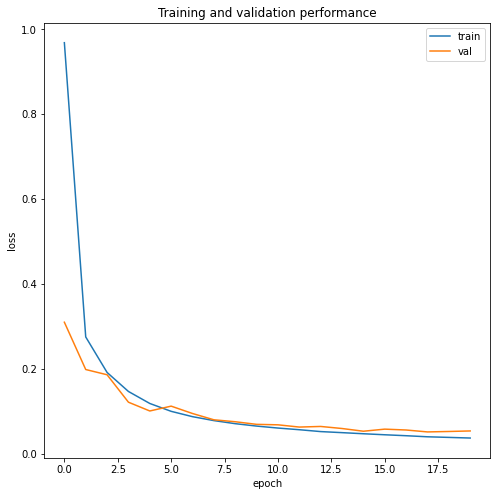

In [41]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
# plt.ylim(0.2, 0.8)

Is it overfitting? What can you say about it when you compare with the denser architecture?
What else can you do to reduce it?

**Answer:** it is slightly overfitting towards the end of the iterations. However, it is less significant than the one we get with the denser architecture. If we wish to reduce it, we can reduce the number of epochs, or add a regularization term to the loss function. Because we have less params in this network, it seems more feasible.

# Visualizing the Feature Maps

We can try to understand what is happening in the network by looking at its feature maps. Since they are defined on a grid, we can vizualize them as images.

Here we vizualize the feature maps of the first layer for some images.

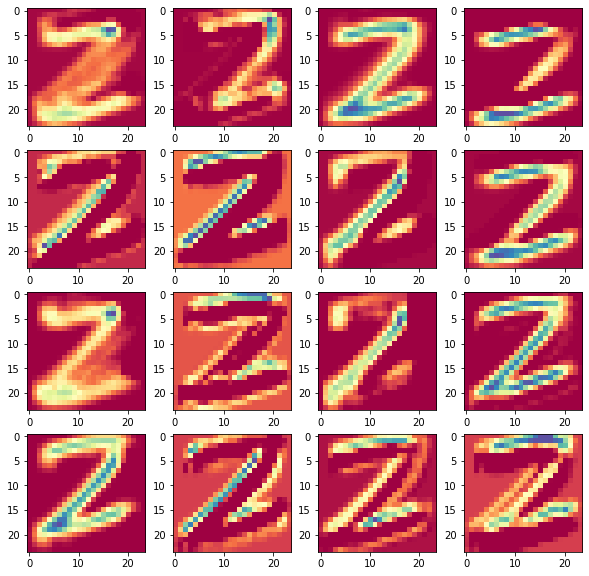

In [47]:
im = x_test[np.random.randint(0, x_test.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

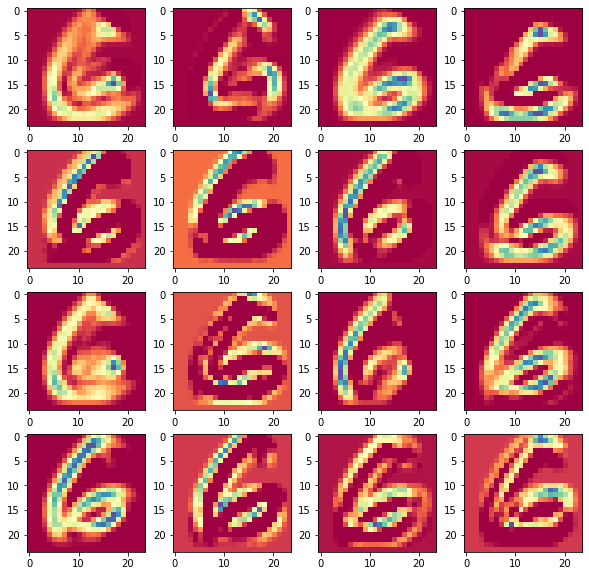

In [49]:
im = x_test[np.random.randint(0, x_test.shape[0]), :, :, :]
im = im[np.newaxis, ...]
fmaps = model.layers[0](im)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fmaps[0,:,:,i])

Can you identify if the convolutional layer detects meaningful features?(for example edges and corners)

**Answer:** I noticed that some features of the convulutional layer are dedicated to detecting the borders of the numbers. Others detect the "content" of the number. Some also detect the corners. It is interesting to note that each feature seems to be optimized to indeed detect a particular feature of the image.

# Improving your network

As before, try to improve your network by changing the number of layers of each time and the number of feature maps, neurons or kernel size.

What is your best validation accuracy?

**Answer**: my best validation accuracy is 0.986. I multiplied by 2 the number of channels in the first layer and changed the first kernel to 7.

In [54]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model2 = Sequential()

model2.add(Conv2D(32, 7, activation='relu', input_shape=x_train.shape[1:]))
model2.add(MaxPool2D())
model2.add(Conv2D(32, 3, activation='relu'))
model2.add(MaxPool2D())
model2.add(Conv2D(32, 3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(num_classes, activation='softmax', name="last"))

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 22, 22, 32)        1600      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)              

In [55]:
learning_rate = 0.01
model2.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=learning_rate),
              metrics=['accuracy'])

In [56]:
batch_size = 64
epochs = 20
output = model2.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(x_val, y_val),
)

Epoch 1/20
844/844 [==============================] - 6s 6ms/step - loss: 1.0607 - accuracy: 0.6711 - val_loss: 0.2934 - val_accuracy: 0.9140
Epoch 2/20
844/844 [==============================] - 5s 6ms/step - loss: 0.2446 - accuracy: 0.9254 - val_loss: 0.1790 - val_accuracy: 0.9485
Epoch 3/20
844/844 [==============================] - 5s 6ms/step - loss: 0.1665 - accuracy: 0.9495 - val_loss: 0.1599 - val_accuracy: 0.9522
Epoch 4/20
844/844 [==============================] - 5s 6ms/step - loss: 0.1313 - accuracy: 0.9601 - val_loss: 0.1205 - val_accuracy: 0.9645
Epoch 5/20
844/844 [==============================] - 6s 7ms/step - loss: 0.1100 - accuracy: 0.9664 - val_loss: 0.1100 - val_accuracy: 0.9668
Epoch 6/20
844/844 [==============================] - 5s 6ms/step - loss: 0.0970 - accuracy: 0.9702 - val_loss: 0.0947 - val_accuracy: 0.9727
Epoch 7/20
844/844 [==============================] - 5s 6ms/step - loss: 0.0872 - accuracy: 0.9724 - val_loss: 0.0875 - val_accuracy: 0.9752
Epoch 

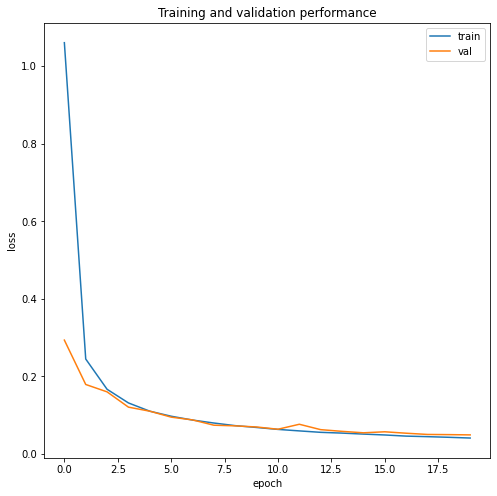

In [57]:
plt.plot(output.epoch, output.history['loss'], label='train')
plt.plot(output.epoch, output.history['val_loss'], label='val')
plt.title('Training and validation performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
# plt.ylim(0.2, 0.8)

# Optional: Experimenting with a more complex database

We will now move to the fashion MNIST database, in order to experiment with a more complex database. The best test accuracy reported on this database is 0.967 (see https://github.com/zalandoresearch/fashion-mnist).



In [ ]:
from tensorflow.keras.datasets import fashion_mnist as db

# You can use the following dictionary to transform number labels into meaningfull labels:
fashion_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
    }

print(fashion_dict[2])

Build your own model below, train it on the fashion MNIST database and analyse its results. Try to reach the highest validation accuracy. Finally, evaluate it using the test database.

You must respect the following constraints:

* you can use dense, convolutional, and pooling layers in your network;

* do not change the optimizer, the loss or the metrics used during training.



In [ ]:
# Your code comes here. You can use several cells.

# Your results on the fashion MNIST database

Which pairs of classes are the main cause of confusion?

**Answer**: ...


Did you use an architecture different than the one used for MNIST? If so, how?

**Answer**: ...


Is there overfitting?

**Answer**: ...

**Test accuracy**: ...